# TensorFlow Probability ile VAE Mantığı

In [1]:
!nvidia-smi

Thu Oct 20 21:31:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    47W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from typing import Dict, Tuple
import pathlib

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape


import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

print(f"TF Version {tf.__version__} \nTFP Version {tfp.__version__}")

TF Version 2.9.2 
TFP Version 0.16.0


## Verilerin Ayarlanması

### Resim Tip Kontrolü

In [5]:
def count_extensions(path: str) -> Dict:
    """
    Verilen path'i subfolder şeklinde kontrol edip içindeki resimlerin uzantılarını subfolder key'i ile döndürür.
    :param path: Str
    :return: Dict
                Örn:  { 'daisy': {'.jpg': 633},
                        'dandelion': {'.jpg': 898},
                        'roses': {'.jpg': 641},
                        'sunflowers': {'.jpg': 698, '.png': 1},
                        'tulips': {'.jpg': 799} }
    """
    image_types = {}
    for image_path in pathlib.Path(path).glob("*/*"):

        current_class = image_path.parent.name
        current_extension = image_path.suffix

        if current_class not in image_types:
            print(f"\nSınıf: {current_class}")
            image_types[current_class] = {}

        if current_extension not in image_types[current_class]:
            print(f"\tBulunan uzantı: {current_extension} for class {current_class}")
            image_types[current_class][current_extension] = 0

        image_types[current_class][current_extension] += 1
    return image_types

In [6]:
image_extensions = count_extensions("flower_photos")


Sınıf: sunflowers
	Bulunan uzantı: .jpg for class sunflowers

Sınıf: tulips
	Bulunan uzantı: .jpg for class tulips

Sınıf: roses
	Bulunan uzantı: .jpg for class roses

Sınıf: dandelion
	Bulunan uzantı: .jpg for class dandelion

Sınıf: daisy
	Bulunan uzantı: .jpg for class daisy


In [7]:
# Görüldüğü üzere sadece .jpg uzantılı resimler mevcut.
# tf.data pipeline'ı kurarken bu bilgiyi kullanacağız.
image_extensions

{'sunflowers': {'.jpg': 699},
 'tulips': {'.jpg': 799},
 'roses': {'.jpg': 641},
 'dandelion': {'.jpg': 898},
 'daisy': {'.jpg': 633}}

### Hızlıca Göz Atış

In [8]:
class_names = list(image_extensions.keys())
total_images = len(list(pathlib.Path("flower_photos").glob("*/*")))

print(f"Sınıf isimleri: {class_names}")
print(f"Toplam resim sayısı: {total_images}")

Sınıf isimleri: ['sunflowers', 'tulips', 'roses', 'dandelion', 'daisy']
Toplam resim sayısı: 3670


In [9]:
# Her sınıftan rastgele bir resim seçelim.
randomly_selected_images = []
for class_name in class_names:
    randomly_selected_images.append(
        np.random.choice(list(pathlib.Path("flower_photos").glob(f"{class_name}/*")))
    )
assert len(randomly_selected_images) == len(class_names)

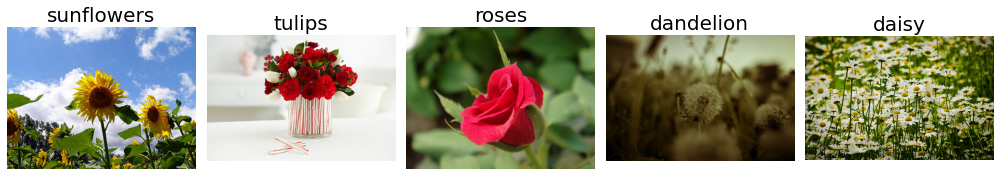

In [10]:
plt.figure(figsize=(14, 7))
for i, image_path in enumerate(randomly_selected_images):
    label = image_path.parent.name
    image = plt.imread(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)

    plt.title(label, fontsize=20)
    plt.axis("off")

    plt.tight_layout()
plt.show()

## tf.data Pipeline

In [11]:
# Burada dosya konumlarını içeren bir tf.data objesi oluşturuyoruz. Aslında çok fazla dosyamız
# olduğunda bu yöntem GPU'da çok büyük bir yer işgal edecektir. 2GB ve daha büyük verisetleri
# için bir generator yazıp bunu tf.data.Dataset.from_generator() ile kullanmak GPU açısından
# daha verimli olacaktır.
dataset = tf.data.Dataset.list_files("flower_photos/*/*.jpg", shuffle=False)

# Yukarıda shuffle=True dersek reshuffle_each_iteration=True olacaktır. Biz bu verisetini
# train ve test olarak ikiye ayıracağımız ve işimizi garantiye alıp data leak yapmamak adına
# shuffle() methodunu kendimiz çağırıyoruz.

dataset = dataset.shuffle(total_images, reshuffle_each_iteration=False)

paths_first_time = []
for image_path in dataset.take(5):
    print(image_path.numpy())
    paths_first_time.append(image_path.numpy())

b'flower_photos/daisy/3598615130_578ed30e5f.jpg'
b'flower_photos/roses/18990187093_09f2bff8fc_m.jpg'
b'flower_photos/sunflowers/19442589512_e733cfea0f.jpg'
b'flower_photos/dandelion/16242239484_51286673af.jpg'
b'flower_photos/dandelion/163702807_e508544acd_n.jpg'


In [12]:
paths_second_time = []
for image_path in dataset.take(5):
    print(image_path.numpy())
    paths_second_time.append(image_path.numpy())

if paths_second_time == paths_first_time:
    print("\n\n**Aynı**!")

b'flower_photos/daisy/3598615130_578ed30e5f.jpg'
b'flower_photos/roses/18990187093_09f2bff8fc_m.jpg'
b'flower_photos/sunflowers/19442589512_e733cfea0f.jpg'
b'flower_photos/dandelion/16242239484_51286673af.jpg'
b'flower_photos/dandelion/163702807_e508544acd_n.jpg'


**Aynı**!


Eğer yukarıda `shuffle=True` deseydik, iki liste aynı olmayacaktı. Bunun sebebi de dataset üzerinde her iterate edişimizde farklı elemanların gelmesinden kaynaklanacaktı. Data leak olmaması için bu şekilde yaptık.

In [13]:
# Verilerin %80'ini train, kalanı ise test için olacak.
train_size = int(0.8 * total_images)
test_size = total_images - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

### Resimleri okuyup decode etmek

In [14]:
def read_image_and_label(image_path: tf.string) -> Tuple[tf.Tensor, tf.Tensor]:
    
    # Resmi oku
    image = tf.io.read_file(image_path)
    
    # Okunan resmi decode et. Bütün hepsi jpg olduğu için burada direkt 
    # decode_jpeg fonksiyonunu kullanabiliyoruz.
    # channels = 3, RGB resimler istiyoruz.
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Hepsini 128x128 yapıp, normalize ediyoruz. 
    image = tf.image.resize(image, [128, 128]) / 255.0

    # Float32 olduğundan emin ol.
    image = tf.cast(image, tf.float32)
    
    # VAE modeli kullanacağımız için classlara (label) ihtiyacımız yok.
    # Resimlere karşılık gelen değerleri yine kendileri olacak şekilde döndürüyoruz.
    return image, image

### tf.data `interleave`

Kısaca her bir resmi tek tek alıp resize edip, batchlemek yerine:
 * Cycle length kadar eleman alalım ve bunlar dataset olsun.
 * Block length kadarını preprocess edelim.
 * Datasette elemanlar bittiğinde bu tekrar edilsin.
 
Bunları TensorFlow'un karar vermesi için `AUTOTUNE` özelliğini kullanıyoruz.

In [15]:
def prepare_dataset(dataset: tf.data.Dataset) ->  tf.raw_ops.PrefetchDataset:
    return dataset.interleave(
                    lambda x: tf.data.Dataset.from_tensors(x).map(read_image_and_label),
                    num_parallel_calls=tf.data.AUTOTUNE,
                    # Burada ek olarak block_length diye bir parametre daha var ve default değeri 1.
                    # Farklı değerler vererek train hızını nasıl dğeiştini gözlemleyebilirsiniz.
                    cycle_length=tf.data.AUTOTUNE)\
                .batch(64)\
                .prefetch(tf.data.AUTOTUNE)

train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset)

#### prefetch() nasıl çalışır?
`prefetch()` methodu, model eğitimi ve ön işleme sürecini overlap etmeye yarayan bir fonksiyodundur. Örnek olarak, GPU n. adımdaki gelen resimleri/verileri işleyip hesaplama yaparken, CPU da bir sonraki adımı hazırlıyor olacak.

Kısaca CPU, GPU model eğitimi yaparken boşta durmayacak, sonraki batch'i hazırlıyor olacak.

In [16]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

## VAE Anlatımı

### VAE'nin Asıl Amacı
Variational Autoencoder, generative yani üretken bir modeldir. Bundan ötürü hedef verisetine benzeyen örnekler üretmeyi hedefler.

Hedef verisetine benzeyen örnekler üretmek için de verinin PDF'sini (probability density function) modellemeye çalışır. 

### Görüntülerle Çalışmak
Pikseller arasındaki bağlantılar & ilişkiler aslında VAE için büyük bir zorluk ortaya çıkarır. Eğer her piksel birbirinden bağımsız olsaydı, her birinin PDF'sini bağımsız olarak öğrenebilirdik ki örneklemek de kolay olurdu.

### VAE'de Latent Space
Okulda herkesin resim çizdiği dönemler olmuştur. Mesela çöp adam çizeceksiniz, onu önce kafanızda tasarlarsınız. Kafasını yuvarlak, kollarını çizgi halinde çizeyim ve aynı zamanda bunlar birbiri ile oranlı olsun vb. şeklinde bir süreç olur. Aslında baktığımız zaman bu resim belli başlı çizgilerden meydana gelmiştir. Bu çizgilerle resmi anlatabiliriz. Verdiğim örneği biraz daha matematiksel olacak şekilde düzenlersek:
 * Verisetimizdeki her resmi en az 1 boyutlu olacak şekilde vektörlerle ifade edebilmeliyiz. VAE de aslında verilen resmi vektörlerle ifade etmeye çalışıyor. Bu vektörler de aynı çöp adam örneğinde de olduğu gibi, çiçekleri üretebilmek-kodlamak için bilgiler içermeli. Çiçek boyu, genişliği vb. şeklinde işe yarar bilgiler olabilir. Ne kadar çok vektör kullanırsak o kadar çok bilgi kodlamış gibi düşünebiliriz.
 
#### İşin Matematiği
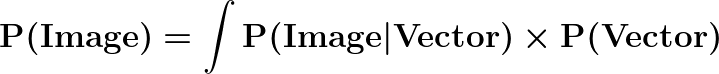

Yeni resimler oluşturabilmemiz vektörlerin bulunduğu uzayda dolaşmamız gerekiyor. Yukarıdaki integral de aslında tam olarak bunu gösteriyor. Vektörlerin bulunduğu uzayı araştırıyoruz. İntegrali biraz daha bilinen bir forma koyacak olursak:

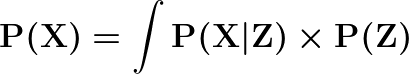

**X'leri verilen vektörlerle yani Z'lerle oluşturabilir miyim? Bu integral işte tam olarak bunu soruyor.**
 * $P(X)$'in değerinin büyük olmasını istiyoruz ki bu sayede benzer örnekler üretebilelim. Bunun için:
   * $P(Z)$ ve $P(X|Z)$'nin de büyük olması gerekir  

### VAE Eğitimi
$P(X)$ direkt olarak kullanılamaz, buna "intractable" denir. Bunun 2 nedeni olabilir: 
 * Verisetinin dağılımını bir fonksiyon veya formulasyon kullanarak ifade edemeyiz
 * İfade edebilsek bile hesaplamak çok maliyetlidir. (Örnek sayısı ile en İYİ İHTİMALLE exponential artan süreler)
 
Bu yüzden $P(X)$ "approximate" etmeliyiz, tam değerini bulmak yerine yaklaşık hesabı yapacağız. Eğitim sürecine başlamak için bir $P(Z)$ seçeceğiz, bunu **prior** olarak adlandıracağız. **Prior** seçimi mantıklı herhangi bir dağılım olabilir. Genellikle Normal dağılım kullanılır, bunun da çeşitli sebepleri vardır. Bazıları:
 * Yeterince karmaşık herhangi bir fonksiyon normal dağılım ile ifade edilebilir.
 * KL-Divergence hesabı yaparken, 2 normal dağılım arasındaki divergence analitik olarak hesaplanabilir.
 
### Eğitim Süreci
İlk adım prior diye seçtiğimiz dağılımdan örnek almak olacaktır. Sonraki ise $P(X|Z)$'i hesaplayarak yaklaşık $P(X)$ değerine ulaşacağız. Özetleyecek olursak:
 * Örnek(ler) al $Z_{N}$ ~ $P(Z)$
 * Alınan örneklerle ~ $\frac{1}{N}\sum_{i=1}^{N}P(X|Z_{i})$
 * Son olarak $P(X)$ yaklaşık değerini hesapla.
 
İsmini başlangıçta söylememiş olsak da bir **Monte Carlo** yaklaşımını benimsemiş olduk. Şimdi ise Gradient Descent ile optimizasyon uygulayabiliriz.

#### Uygulayabiliriz değil mi?

### Eğitim Sürecindeki Zorluklar
Uygulayabiliriz evet ama burada malesef bir sorun ortaya çıkıyor: **Curse of Dimensionality**. 

Burada çok boyutlu fonksiyonlarla iş yaptığımız için priordan aldığımız örnekler yetersiz kalabilir. Unutmamak gerekir ki, $P(X)$'in yaklaşık değerini hesaplıyoruz ve bu çok boyutlu problemde güzel bir yakınsama elde etmek için çok fazla örnek almak gerekir. Bu kadar fazla örnek alsak bile, örneklerin gerçek veriseti ile ilişkisi olacağının garantisi yoktur. 
 * **Hatırlatma:** Alınan vektörler, resimlerin nasıl çizileceğinin komutlarını anlatmalıdır mantığı ile hareket ediyoruz.

### VAE'de KL-Divergence
Priordan rastgele örnekler aldığımız zaman çok işimize yaramayacaklar. Biraz daha mantıklı davranıp, nasıl örnekler almamız gerektiğini bulup, onları kullanabiliriz. 

Yeni bir dağılım oluşturalım, ismine genelde **Q** denilir ve $Q(Z|X)$ olarak gösterilir. Amacımız bu dağılımı da aynı anda eğitip, priordan işimize yarayacak örnekler almayı öğrenmektir. Temel fikir budur.

Maksimize etmeye çalıştığımız fonksiyon: 

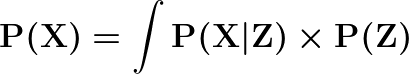

Fakat işin içine $Q(Z|X)$ girdiği için bunu biraz değiştirmemiz gerekiyor:
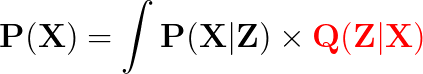

Bir dağılımın yerine başka bir dağılım kullanıp, ikisi arasında ilişki kurmayı gördük. Şu zamana kadar maksimize etmeye çalıştığımız fonksiyonda $P(X)$'de vektörlere bağlı bir koşul yoktu. Ama VAE'de encoder ve decoder olarak beraber çalışacağımız için yaklaşımımızı biraz değiştirmemiz gerekiyor. 

### Bayes Teoremi, Variational Bayes ve KL-Divergence
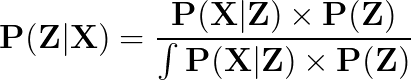

Eşitliğin sol tarafındaki dağılım, posterior dağılım olarak isimlendiriliyor. Terimlere bakacak olursak:
 * $P(Z|X)$ = Posterior dağılım. Encoder kısmında bunu modellemeye çalışıyoruz.
   * Açıklaması: Bir veri verildiğinde, elimizdeki vektör ne kadar olasıdır (how likely)?
 * $P(X|Z)$ = Likelihood. Decoder kısmında da bunu modellemek gerekiyor.
   * Açıklaması: Bir **Z** vektörü verildiği takdirde, elimizdeki veri ne kadar olasıdır? (Burada veri = resim oluyor)
 * $P(Z)$ = Prior
 * Payda = $P(X)$ = Evidence, Marginal likelihood. **Z**'nin tüm değerleri için çözülmesi gereken bir integraldir. Hesaplanması çoğu zaman mümkün değildir.
 
Posterior dağılımı matematiksel olarak hesaplamak mümkün olmadığı için bunu başka bir dağılımla yaklaşık hesabı yapmamız gerekiyor. Bu dağılımı $Q(Z|X)$ olarak yazalım.

#### Q(Z|X)'nin posterior'a ne kadar benzediğini anlamak için KL-Divergence kullanacağız. Neticede ikisi arasında çok fark OLMAMASINI isteriz.

* KL-Divergence, iki dağılımın birbirine ne kadar BENZEMEDİĞİNİ ölçer. Bunun için KL-Divergence ne kadar küçük olursa, dağılımlar o kadar benziyor demektir. Formulasyona bakacak olursak:

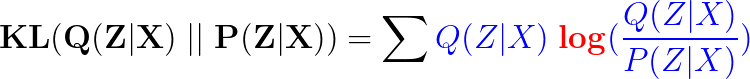

* KL-Divergence formundan asıl loss fonksiyonuna doğru giderken arada çok fazla matematiksel işlem olduğu için direkt olarak sonuca gelmek istiyorum: 
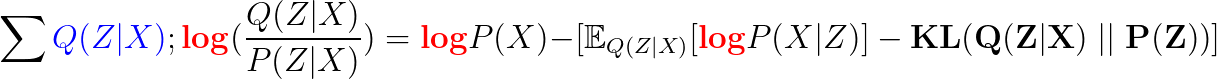

* Bunu biraz daha şirin bir hale getirecek olursak:

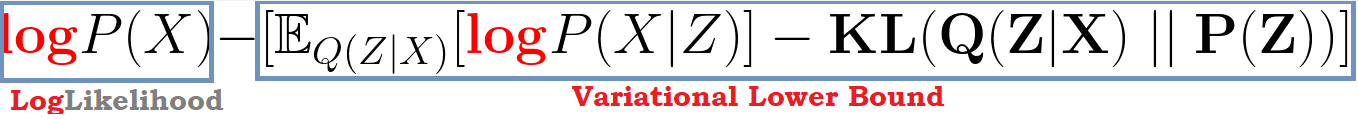

#### Toplayacak olursak:

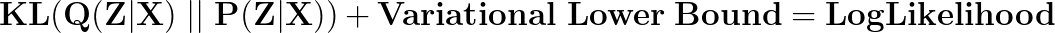

#### Eşitliğin sağ tarafında başta gördüğümüz likelihood teriminin log içinde kaldığını görürüz:
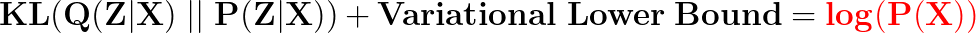

#### Variational Lower Bound:
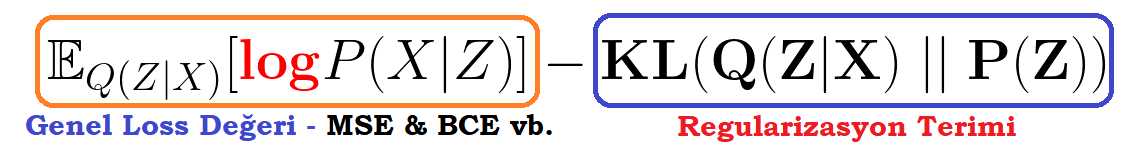

* Regularizasyon terimi olmadan VAE aslında bir auto-encoder'a dönüşmüş oluyor.
* Regularizasyon ile vektörlerin (reconstruction için gerekli bilgileri içeren vektörler, çöp adam örneği) uzayda her yere dağılmaması sağlanıyor.

### Gerçekten Nasıl Train Edeceğiz? :)

İlk başta da anlattığım gibi, amacımız $P(X)$'i maksimize etmek. Bunun için de **Variational Lower Bound**'u maksimize etmeliyiz.

Fakat sol tarafta bir expectation (beklenen değer) var. Backpropagation için elimizde belli değerler olmalı, bunun için de örnekler (sample) alınmalı.

#### Sampling (örneklem alma) türevlenebilir bir fonksiyon (not differentiable) değildir. Bunun için de reparameterization trick kullanılır.

### Reparameterization Trick
Kısaca, dağılımlardan örneklem alma operasyonu türevlenebilir olmadığından, örneklem alma işleminin parametrize hale getirilmesidir.

Elimizde $Normal(0, 10)$ dağılım olsun. Reparameterization Trick ile örneklem alma işlemi:
 * İlk olarak dağılımdan örnekler alınır.
 * **Son değerler** = Ortalama + ilk alınan değerler $\times$ Standart Sapma

### VAE Diagramı

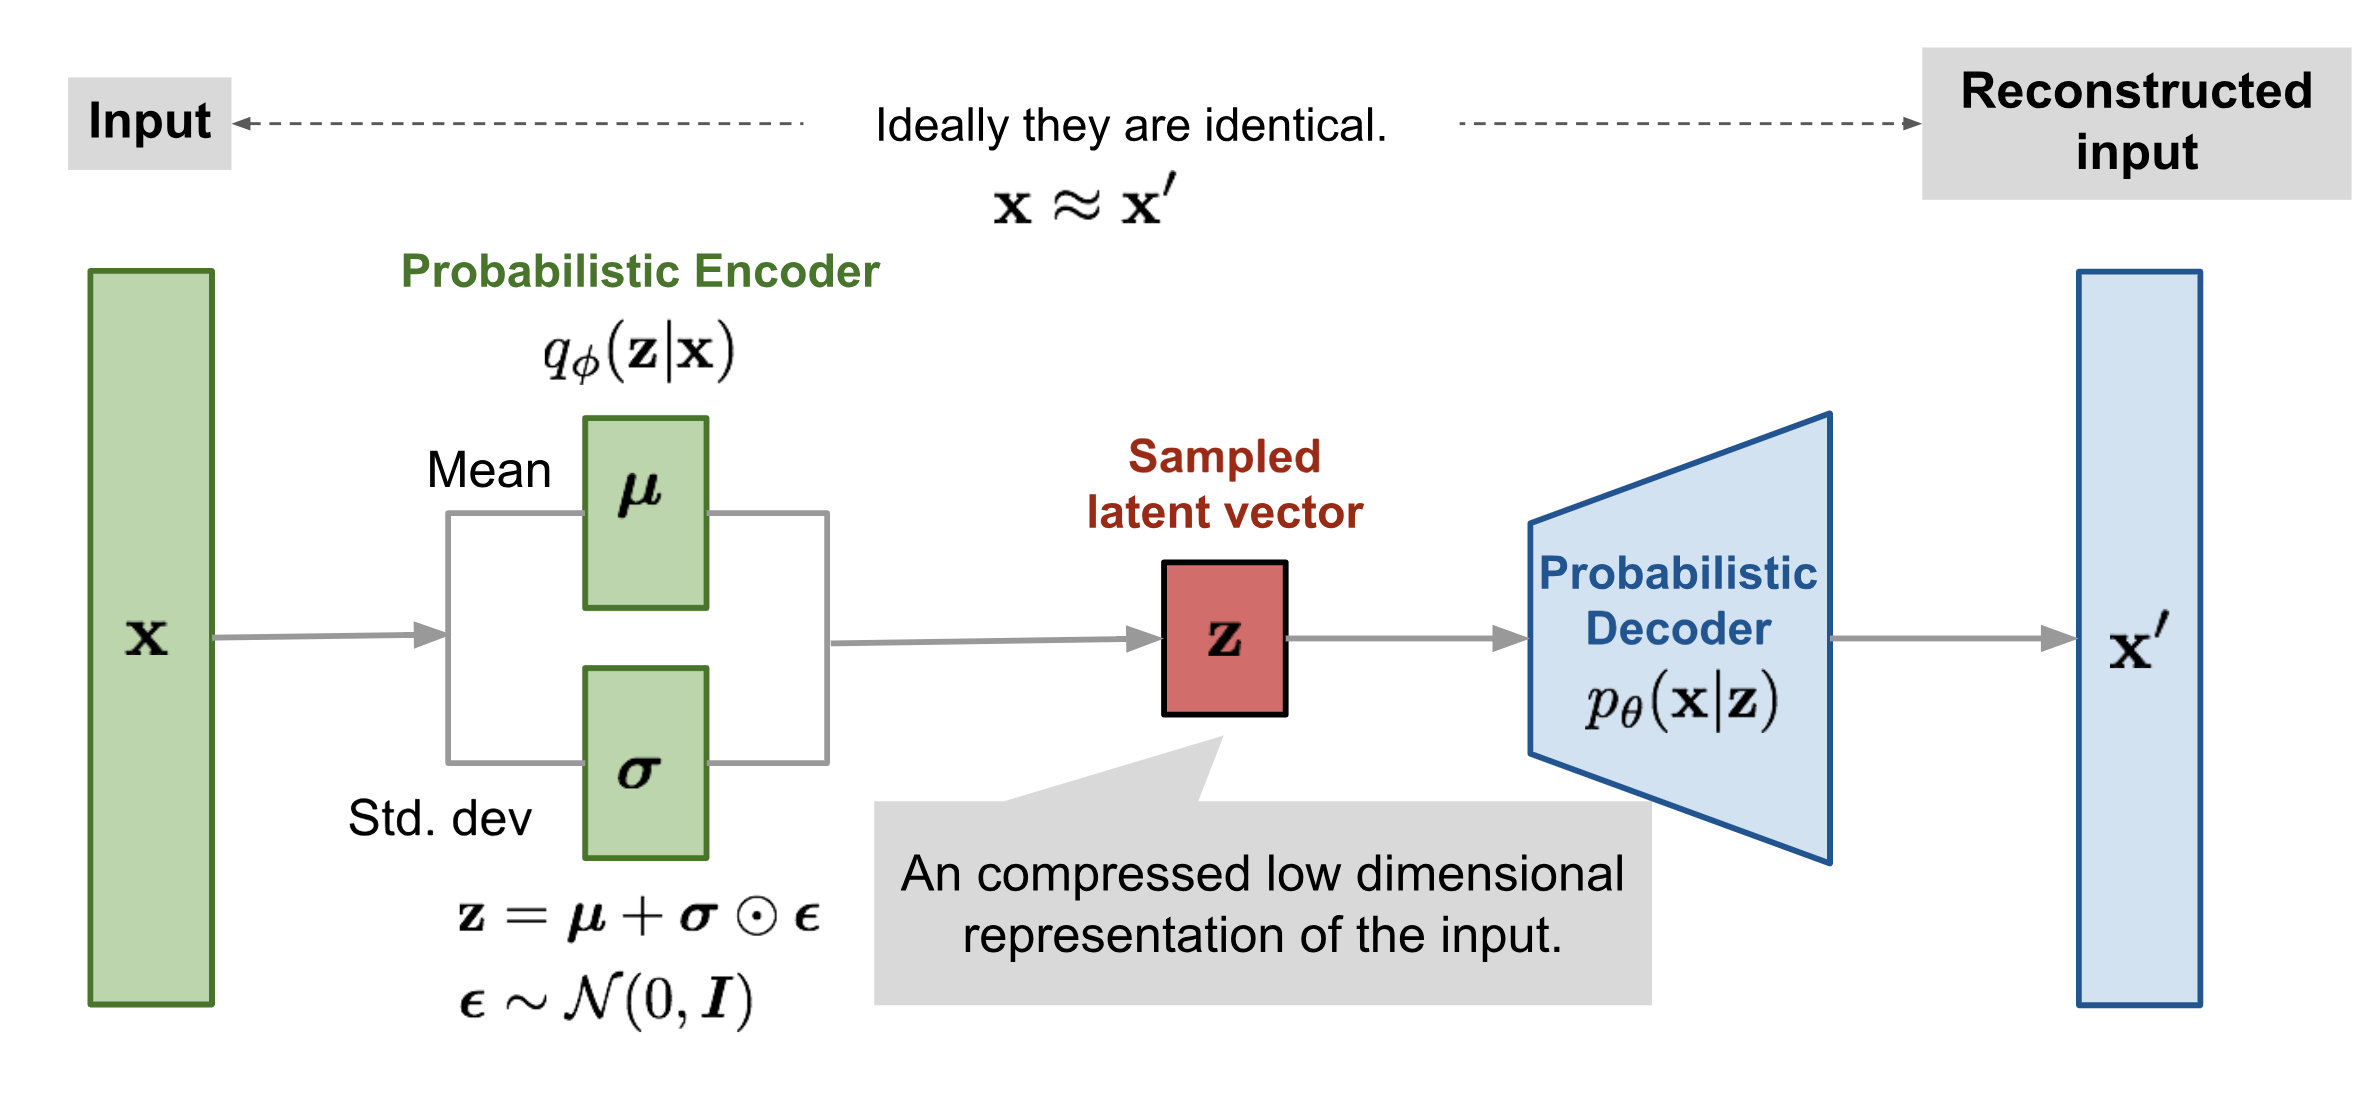

Kaynak: https://lilianweng.github.io/posts/2018-08-12-vae/

### Type-II Maximum Likelihood Estimation
* Burada prior'un parametrelerini `(loc - scale_diag)` de train ediyoruz, buna Tip-II Maximum Likelihood Estimation deniyor. Daha derinlemesine araştırmak isterseniz `Empirical Bayes` konusuna bakmanız gerekiyor
* Bu sayede prior'un ortalaması ve varyansını direkt olarak baştan belirlemek zorunda değiliz ki bu da zor olurdu. Çünkü veri hakkında önsel bilgimiz mevcut değil :)

In [17]:
def get_prior(latent_dim: int) -> tfd.Distribution:
    """
    Prior olarak multivariate bir normal dağılım seçiyoruz
    ve parametrelerini rastgele atıyoruz. Çünkü bunlar train edilebilir olacak.,
    
    latent_dim: Latent space boyutu, vektörlerimizin boyutu.
    """
    mvn_prior = tfd.MultivariateNormalDiag(
            
            loc=tf.Variable(
                    tf.random.uniform(shape=(latent_dim, ), 
                                      minval=-2.4, maxval=2.8),
                    trainable=True,
                    dtype=tf.float32,
                    name='mvn_prior_loc'),
            
            # Standart sapmanın her zaman 0'dan büyük olduğuna emin olmalıyız.
            # Onun için TransformedVariable kullanıp, elde edilen değerlere bijector
            # uyguluyoruz. Burada aktivasyon uygulama mantığını benimsemiş gibi düşünebilirsiniz.
            # Softplus'a giren değerler hep pozitif olacak.
            scale_diag=tfp.util.TransformedVariable(
                           initial_value=tf.random.uniform(shape=(latent_dim, ),
                                                           minval=0.8, maxval=2.8),
                           bijector=tfb.Softplus(), # tfb.Exp() de kullanılabilir. Denemek lazım.

                           trainable=True,
                           dtype=tf.float32,
                           name='mvn_prior_scale'))
    return mvn_prior

In [18]:
latent_dim = 16
prior = get_prior(latent_dim=latent_dim)
prior

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[16] dtype=float32>

In [19]:
prior.mean()

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 1.3192043 , -1.6845957 ,  2.243483  ,  1.4959867 , -1.1021028 ,
        1.5287936 , -1.0698339 ,  1.3198547 , -0.9470024 ,  2.1469889 ,
       -0.11993456, -1.4613578 ,  1.642592  ,  2.1722631 ,  1.2560315 ,
       -1.246972  ], dtype=float32)>

In [20]:
prior.stddev()

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([2.2695024, 0.9777971, 1.473005 , 2.2645135, 1.8173583, 1.5260534,
       2.3404722, 0.8304721, 2.725672 , 2.2240198, 2.24103  , 1.9078755,
       1.8677039, 1.5462325, 2.154173 , 1.2094312], dtype=float32)>

## Regularization Loss'u Eklemek

In [21]:
def get_kl_regularizer(prior_distribution) -> tfpl.distribution_layer:
    # KL-Divergence'ı modelimize eklemek için KLDivergenceRegularizer layerını kullanacağız.
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=True, # Prior -> Normal dağılım, Encoder çıktısı da aynı tipte olursa KL Divergence'ın analitik değerini
                           # kullanabiliriz. MCMC yapmaya gerek kalmayacak.
        weight=1.0,
        # test_points_fn=lambda q: q.sample(10), use_exact_kl=False olsaydı, MCMC için kaç örnek kullanalım?
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [22]:
kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

## Basitçe VAE Modelinin Oluşturulması

### Encoder

In [23]:
encoder = Sequential([
        Conv2D(32, (3, 3), activation='relu', strides=2, padding='SAME', input_shape=(128, 128, 3)),
        BatchNormalization(),
        
        Conv2D(64, (3, 3), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        
        Conv2D(128, (3, 3), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        
        Conv2D(256, (3, 3), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        
        Flatten(),
        
        # Çıktı ve önceki dense layerdaki unit sayısı birbirine bağımlı olduğundan
        # bunu TensorFlow Probability'nin ayarlamasını istiyoruz. params_size bu işe yarıyor.
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        
        # MultivariateNormalTriL layerındaki TriL, lower triangular'dan geliyor. Bu layer bizim için aynı covariance'ları
        # da hesaba katıyor. Ondan dolayı latent_dim'i artırırsak parametre sayısının hemen katlandığını görebiliriz.
        # KL-Divergence eklemek için activity_regularizer parametresine tfpl.KLDivergenceRegularizer geçmek yeterli.
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])

In [24]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 128)      5

### Decoder

In [25]:
decoder = Sequential([
        Dense(256 * 8 * 8, activation='relu', input_shape=(latent_dim, )),
        Reshape((8, 8, 256)),
        
        UpSampling2D(size=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
            
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
            
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        
        Flatten(),
        
        # Çıktı shape'i, resimlerin shape'i ile eşleşmek zorunda.
        # convert_to_tensor_fn ile bu prob. dist.'ten değerleri nasıl alacağımıza karar veriyoruz.
        # mean, mode olabilir veya logits. Önceki layerda aktivasyon olmadığı için network logit output
        # ediyor olacak. Bundan ötürü tfd.Bernoulli.logits seçildi.
        tfpl.IndependentBernoulli(event_shape=(128, 128, 3),
                                  convert_to_tensor_fn = tfd.Bernoulli.logits)
    ])

In [26]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             278528    
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)      

In [27]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

### Negative Log-Likelihood Loss

In [28]:
def average_nll(batch_of_images, decoding_dist):
    """
    Batchlerin ortalaması olan negative log-likelihood'u döndürür. 
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

### Model Eğitimi

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer, loss=average_nll)

In [30]:
vae.fit(train_dataset, validation_data=test_dataset, epochs=64)

Epoch 1/64
46/46 [==============================] - 11s 87ms/step - loss: 32204.4492 - val_loss: 33731.4180
Epoch 2/64
46/46 [==============================] - 2s 45ms/step - loss: 30507.1016 - val_loss: 33368.8438
Epoch 3/64
46/46 [==============================] - 2s 43ms/step - loss: 29473.0020 - val_loss: 32407.7949
Epoch 4/64
46/46 [==============================] - 2s 43ms/step - loss: 28786.3633 - val_loss: 31612.3730
Epoch 5/64
46/46 [==============================] - 2s 43ms/step - loss: 28454.9609 - val_loss: 30613.2129
Epoch 6/64
46/46 [==============================] - 2s 43ms/step - loss: 28183.9180 - val_loss: 29706.9707
Epoch 7/64
46/46 [==============================] - 2s 43ms/step - loss: 27962.5312 - val_loss: 28921.0781
Epoch 8/64
46/46 [==============================] - 2s 43ms/step - loss: 27820.5605 - val_loss: 28391.4004
Epoch 9/64
46/46 [==============================] - 2s 43ms/step - loss: 27699.9375 - val_loss: 27960.7676
Epoch 10/64
46/46 [=================

## Örnek Üretimi

### Prior'dan Sample Almak

In [31]:
# Prior'dan örnek alıp bunu decoder'ın çözmesini isteyeceğiz.
sampled = prior.sample(1)
sampled

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.20740247, -2.777659  ,  3.61417   ,  5.000333  , -3.77487   ,
         1.574521  ,  3.595205  , -0.09186268,  0.33488488,  2.195578  ,
        -2.3053222 , -3.9718983 , -1.5958282 , -1.1331928 ,  3.2903059 ,
        -1.004298  ]], dtype=float32)>

In [32]:
# _TensorCoercible, TFP'nin Keras ile uyumlu çalışmasını sağlayan wrapper bir classtır. 
# mean(), stddev() gibi methodları vardır, aynı distribution objectleri gibi...
decoder(sampled)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[128, 128, 3] dtype=float32>

In [33]:
def generate_images(prior: tfd.Distribution, 
                    decoder: tf.keras.Model, 
                    n_samples: int) -> tf.Tensor:
    z = prior.sample(n_samples)
    return decoder(z).mean()

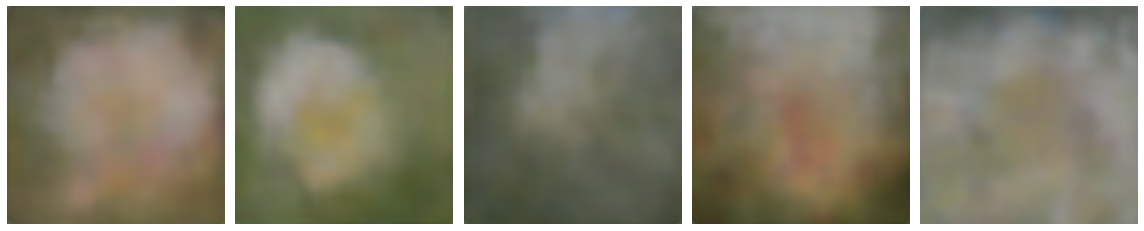

In [37]:
# Model aşırı basit kaldığı için güzel örnekler üretemedi. Daha complex modellerle sonuçlar iyileşecektir.
# Skip connection ve UNET mantığı izlenebilir.
n_samples = 5
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();